# Generation of MGXS for a fuel pin cell, using OpenMC

## Environment

In [128]:
import math
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import openmc
import openmc.mgxs

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo Environnement

In [129]:
import os

%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)


env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


## Initialize empty model

In [130]:
model = openmc.Model()

## Materials
- name is optional

- use `add_nuclide` for nuclides
- use `add_element` for elements

- do not forget $S(\alpha,\beta)$ when needed

In [131]:
uo2 = openmc.Material(name='UO2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.0)

In [132]:
zirconium = openmc.Material(name='Zirc')
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

In [133]:
water = openmc.Material(name='H2O')
water.add_element('H', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.7)

water.add_s_alpha_beta('c_H_in_H2O')

In [134]:
model.materials = openmc.Materials([uo2, zirconium, water])

In [135]:
print(uo2)

Material
	ID             =	10
	Name           =	UO2
	Temperature    =	None
	Density        =	10.0 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U235           =	0.03         [ao]
	U238           =	0.97         [ao]
	O16            =	1.9952412    [ao]
	O17            =	0.000758     [ao]
	O18            =	0.0040008    [ao]



## Geometry
### Surfaces

In [136]:
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)

pitch  = 1.26
left   = openmc.XPlane(x0 =-pitch/2, boundary_type='reflective')
right  = openmc.XPlane(x0 = pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0 =-pitch/2, boundary_type='reflective')
top    = openmc.YPlane(y0 = pitch/2, boundary_type='reflective')

### Regions based on surfaces

In [137]:
fuel_region  = -fuel_or
gap_region   = +fuel_or & -clad_ir
clad_region  = +clad_ir & -clad_or
water_region = +left & -right & +bottom & -top & +clad_or

In [138]:
print(fuel_region)

-22


### Cells (= regions + materials)

In [139]:
fuel_cell = openmc.Cell(name='Fuel')
fuel_cell.fill = uo2
fuel_cell.region = fuel_region

gap_cell = openmc.Cell(name='Gap')
# gap.fill = 'void'
gap_cell.region = gap_region

clad_cell = openmc.Cell(name='Clad')
clad_cell.fill = zirconium
clad_cell.region = clad_region

moderator_cell = openmc.Cell(name='Moderator')
moderator_cell.fill = water
moderator_cell.region = water_region

In [140]:
print(fuel_cell)
print(gap_cell)

Cell
	ID             =	13
	Name           =	Fuel
	Fill           =	Material 10
	Region         =	-22
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None

Cell
	ID             =	14
	Name           =	Gap
	Fill           =	None
	Region         =	(22 -23)
	Rotation       =	None
	Translation    =	None
	Volume         =	None



## Universes

In [141]:
root_universe = openmc.Universe(cells=(fuel_cell, gap_cell, \
                                       clad_cell, moderator_cell))

In [142]:
model.geometry = openmc.Geometry(root_universe)

## Exports to XML

In [143]:
# model.geometry.export_to_xml()

In [144]:
# !cat geometry.xml

## Simulations parameters

In [145]:
# Create a point source
# point = openmc.stats.Point((0, 0, 0))
# source = openmc.IndependentSource(space=point)

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-pitch/2, -pitch/2, -pitch/2, pitch/2, pitch/2, pitch/2]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)

In [146]:
batches = 50
inactive = 10
particles = 2500

# Instantiate a Settings object
settings = openmc.Settings()

settings.source = source
settings.batches = batches
settings.inactive = inactive
settings.particles = particles
settings.run_mode = 'eigenvalue'
settings.output = {'tallies': True}

model.settings = settings
# model.settings.export_to_xml()

In [147]:
# !cat settings.xml

In [148]:
for key in openmc.mgxs.GROUP_STRUCTURES.keys():
    print(key)

CASMO-2
CASMO-4
CASMO-8
CASMO-16
CASMO-25
CASMO-40
VITAMIN-J-42
SCALE-44
MPACT-51
MPACT-60
MPACT-69
CASMO-70
XMAS-172
VITAMIN-J-175
SCALE-252
TRIPOLI-315
SHEM-361
CCFE-709
UKAEA-1102
ECCO-1968


In [149]:
#choose_group = openmc.mgxs.EnergyGroups(group_edges='XMAS-172')
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']

In [150]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


## Run OpenMC

In [151]:
sp_file = model.run()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=391.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=298.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=306.
  warn(msg, IDWarning)


[Machine2:07635] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

In [152]:
!ls -lart


total 74576
drwxrwxr-x 5 pablo pablo     4096 May 15 15:36 ..
drwxrwxr-x 2 pablo pablo     4096 May 15 15:37 .ipynb_checkpoints
-rw-rw-r-- 1 pablo pablo   110251 May 15 16:11 pincell_mgxs_openmc_v1_draft.ipynb
-rw-rw-r-- 1 pablo pablo     9158 May 15 16:12 model.xml
-rw-rw-r-- 1 pablo pablo    47976 May 15 16:12 summary.h5
-rw-rw-r-- 1 pablo pablo 11736400 May 15 16:12 statepoint.50.h5
drwxrwxr-x 3 pablo pablo     4096 May 15 16:12 .
-rw-rw-r-- 1 pablo pablo 64439756 May 15 16:12 tallies.out


## Tally data processing

In [153]:
# Load the last statepoint file
sp = openmc.StatePoint(sp_file)

In [154]:
sp.tallies

{566: Tally
 	ID             =	566
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux', 'total', 'absorption', 'fission', 'nu-fission', 'inverse-velocity']
 	Estimator      =	tracklength
 	Multiply dens. =	True,
 553: Tally
 	ID             =	553
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['nu-fission']
 	Estimator      =	analog
 	Multiply dens. =	True,
 554: Tally
 	ID             =	554
 	Name           =	
 	Filters        =	CellFilter, EnergyoutFilter
 	Nuclides       =	total
 	Scores         =	['nu-fission']
 	Estimator      =	analog
 	Multiply dens. =	True,
 561: Tally
 	ID             =	561
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	analog
 	Multiply dens. =	True,
 562: Tally
 	ID             =	562
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter, 

0
2
1


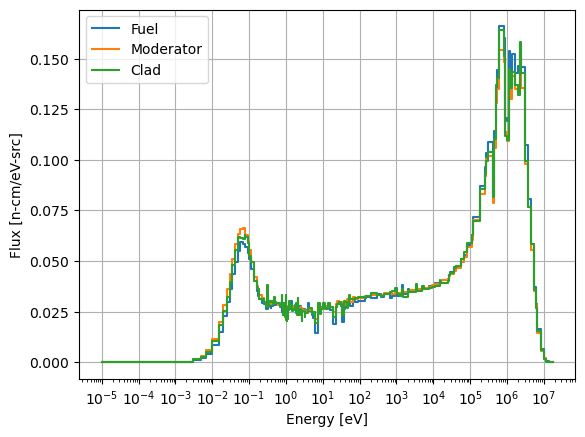

In [155]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

#Enter the name of the cell type string// example: fuel_cell = openmc.Cell(name='Fuel') ///
cell_plot=['Fuel','Moderator','Clad']


sp = openmc.StatePoint(sp_file)
sp.tallies
tally_flux_id=[]
for index, tally in enumerate(sp.tallies):
    if sp.tallies[tally].scores==['flux']:
        t=sp.tallies[tally]

def flux_cell(cell):
    
    cell_index = 99
    cell_id=99
    # print(model.geometry.get_all_material_cells().values())
    i=0
    for all_cell in model.geometry.get_all_material_cells().values():
        i=i+1
        if all_cell.name==cell:
            cell_index=all_cell.id
            cell_id=i-1
            print(cell_id)
            
    tally_data_reshaped =t.get_reshaped_data()
    flux=tally_data_reshaped[cell_id]
    
    liste_reduced = []
    for under_liste in flux:
        nombre = under_liste[0][0]
        liste_reduced.append(nombre)
    flux=liste_reduced
    return(flux)
    

dE=np.diff(choose_group)
Emid=choose_group[:-1]+dE/2

fig, ax = plt.subplots()
for i,cell in enumerate(cell_plot):
    flux=flux_cell(cell_plot[i])    
    mg_spectrum=flux / np.sum(flux)
    ax.step(choose_group[:-1], Emid*mg_spectrum/dE, where='post', label=cell_plot[i])
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
plt.show()


### Print MGXS

In [156]:
#Enter the name of the cell type (openmc.Cell) /// example: fuel_cell = openmc.Cell(name='Fuel') ///

mgxs_lib.load_from_statepoint(sp)
type(mgxs_lib)
reaction_print = 'total'
cell_print=fuel_cell
df_mgxs = mgxs_lib.get_mgxs(cell_print, reaction_print)
df_mgxs.print_xs()

Multi-Group XS
	Reaction Type  =	total
	Domain Type    =	cell
	Domain ID      =	13
	Cross Sections [cm^-1]:
            Group 1 [17332500.0 - 19640300.0eV]:	0.00e+00 +/- 0.00e+00%
            Group 2 [14918200.0 - 17332500.0eV]:	2.05e-01 +/- 1.41e+02%
            Group 3 [13840300.0 - 14918200.0eV]:	2.03e-01 +/- 7.15e+01%
            Group 4 [11618300.0 - 13840300.0eV]:	2.02e-01 +/- 4.28e+01%
            Group 5 [10000000.0 - 11618300.0eV]:	1.91e-01 +/- 1.75e+01%
            Group 6 [8187310.0  - 10000000.0eV]:	1.91e-01 +/- 8.54e+00%
            Group 7 [6703200.0  - 8187310.0 eV]:	1.97e-01 +/- 5.71e+00%
            Group 8 [6065310.0  - 6703200.0 eV]:	1.97e-01 +/- 4.50e+00%
            Group 9 [5488120.0  - 6065310.0 eV]:	2.24e-01 +/- 4.83e+00%
            Group 10 [4493290.0  - 5488120.0 eV]:	2.29e-01 +/- 3.31e+00%
            Group 11 [3678790.0  - 4493290.0 eV]:	2.74e-01 +/- 2.43e+00%
            Group 12 [3011940.0  - 3678790.0 eV]:	2.90e-01 +/- 1.84e+00%
            Group 13 [246

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]


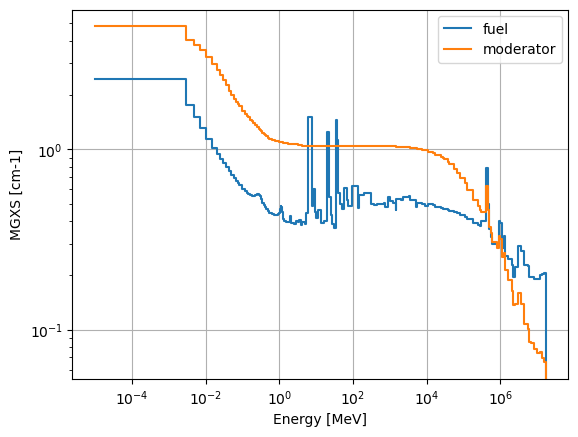

In [157]:
#Enter the name of the cell type (openmc.Cell) /// example: fuel_cell = openmc.Cell(name='Fuel') ///

reaction_plot = 'total'
cell_plot_1 = fuel_cell
cell_name_1='fuel'
cell_plot_2 = moderator_cell
cell_name_2='moderator'


mgxs_plot_1 = mgxs_lib.get_mgxs(cell_plot_1, reaction_plot)

mgxs1=mgxs_plot_1.get_pandas_dataframe(xs_type='macro')['mean'].values
mgxs_plot_2 = mgxs_lib.get_mgxs(cell_plot_2, reaction_plot)
mgxs2=mgxs_plot_2.get_pandas_dataframe(xs_type='macro')['mean'].values


fig, ax = plt.subplots()
ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1) 
ax.step(choose_group[:-1], np.flip(mgxs2), where='post', label=cell_name_2) 

        
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()